# Counting number of allelically imbalanced genes across genetic backgrounds and cell types

## Figure 6C

In [1]:
#libraries
.libPaths( c( .libPaths(), "/home/114/vp4925/R/x86_64-pc-linux-gnu-library/4.3") ) 
suppressPackageStartupMessages({
    library(openxlsx)
    library(dplyr)
    library(ggplot2)
    library(wesanderson)
    library(reshape2)
    library(tidytable)
})

In [ ]:
# Functions
#Make triangle function
make_triangles <- function(x, y, point = "up") {
  x <- as.integer(as.factor((x)))
  y <- as.integer(as.factor((y)))
  
  if (point == "up") {
    newx <- sapply(x, function(x) {
      c(x - 0.5, x - 0.5, x + 0.5)
    }, simplify = FALSE)
    newy <- sapply(y, function(y) {
      c(y - 0.5, y + 0.5, y + 0.5)
    }, simplify = FALSE)
  } else if (point == "down") {
    newx <- sapply(x, function(x) {
      c(x - 0.5, x + 0.5, x + 0.5)
    }, simplify = FALSE)
    newy <- sapply(y, function(y) {
      c(y - 0.5, y - 0.5, y + 0.5)
    }, simplify = FALSE)
  }
  data.frame(x = unlist(newx), y = unlist(newy))
}

In [2]:
#loading beta-binomial test results

cell_types <- c("Deep layer neurons", "Gliogenic progenitor cells", "Hippocampal neurons", "Inhibitory neurons", 
                "Intermediate neuronal prog", "Neurogenic progenitor cells", "Oligodendrocyte prog", "Preplate neurons")
res_dir <- "/g/data/zk16/veronika/projects/vierbuct/github/data/bbtest_res_ASPEN/updated/"
#Hippocamal neurons are not present in CastBl6 data
cast_bb_test <- list()
cast_bb_test_rdc <- list()
for (i in 1:length(cell_types[-3])){
    cast_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_CAST_exons_dispshrunk_updated.xlsx"), sheet = i, rowNames = T)
    #removing hippocamal neurons due to low counts
    cast_bb_test[[i]]$cell_type <- cell_types[-3][i]
    cast_bb_test[[i]]$strain <- "CastB6"
    cast_bb_test[[i]]$log2FC <- ifelse(is.na(cast_bb_test[[i]]$log2FC) & cast_bb_test[[i]]$AI == 1, 12, cast_bb_test[[i]]$log2FC)
    cast_bb_test[[i]]$log2FC <- ifelse(is.na(cast_bb_test[[i]]$log2FC) & cast_bb_test[[i]]$AI == 0, -12, cast_bb_test[[i]]$log2FC)
    cast_bb_test_rdc[[i]] <- cast_bb_test[[i]][,c("fdr_shrunk", "log2FC", "cell_type", "strain")]
}

molf_bb_test <- list()
molf_bb_test_rdc <- list()
for (i in 1:length(cell_types)){
    molf_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_MOLF_exons_dispshrunk_updated.xlsx"), sheet = i, rowNames = T)
    molf_bb_test[[i]]$cell_type <- cell_types[i]
    molf_bb_test[[i]]$strain <- "MolfB6"
     molf_bb_test[[i]]$log2FC <- ifelse(is.na(molf_bb_test[[i]]$log2FC) & molf_bb_test[[i]]$AI == 1, 12, molf_bb_test[[i]]$log2FC)
    molf_bb_test[[i]]$log2FC <- ifelse(is.na(molf_bb_test[[i]]$log2FC) & molf_bb_test[[i]]$AI == 0, -12, molf_bb_test[[i]]$log2FC) 
    molf_bb_test_rdc[[i]] <- molf_bb_test[[i]][,c("fdr_shrunk", "log2FC", "cell_type", "strain")]
}

#Hippocamal neurons are not present in PwkBl6 data
pwk_bb_test <- list()
pwk_bb_test_rdc <- list()
for (i in 1:length(cell_types[-3])){
    pwk_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_PWK_exons_dispshrunk_updated.xlsx"), sheet = i, rowNames = T)
     #removing hippocamal neurons due to low counts
    pwk_bb_test[[i]]$cell_type <- cell_types[-3][i]
    pwk_bb_test[[i]]$strain <- "PwkB6"
    pwk_bb_test[[i]]$log2FC <- ifelse(is.na(pwk_bb_test[[i]]$log2FC) & pwk_bb_test[[i]]$AI == 1, 12, pwk_bb_test[[i]]$log2FC)
    pwk_bb_test[[i]]$log2FC <- ifelse(is.na(pwk_bb_test[[i]]$log2FC) & pwk_bb_test[[i]]$AI == 0, -12, pwk_bb_test[[i]]$log2FC)
    pwk_bb_test_rdc[[i]] <- pwk_bb_test[[i]][,c("fdr_shrunk", "log2FC", "cell_type", "strain")]
}

spret_bb_test <- list()
spret_bb_test_rdc <- list()
for (i in 1:length(cell_types)){
    spret_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_SPRET_exons_dispshrunk_updated.xlsx"), sheet = i, rowNames = T)
    spret_bb_test[[i]]$cell_type <- cell_types[i]
    spret_bb_test[[i]]$strain <- "SpretB6"
    spret_bb_test[[i]]$log2FC <- ifelse(is.na(spret_bb_test[[i]]$log2FC) & spret_bb_test[[i]]$AI == 1, 12, spret_bb_test[[i]]$log2FC)
    spret_bb_test[[i]]$log2FC <- ifelse(is.na(spret_bb_test[[i]]$log2FC) & spret_bb_test[[i]]$AI == 0, -12, spret_bb_test[[i]]$log2FC)
    spret_bb_test_rdc[[i]] <- spret_bb_test[[i]][,c("fdr_shrunk", "log2FC", "cell_type", "strain")]
}

#removing low-abundant cell types - Hippocampal neurons, Inhibitory neurons
cast_bb_test_rdc <- cast_bb_test_rdc[-3]
molf_bb_test_rdc <- molf_bb_test_rdc[-c(3,4)]
pwk_bb_test_rdc <- pwk_bb_test_rdc[-3]
spret_bb_test_rdc <- spret_bb_test_rdc[-c(3,4)]

all_strains <- as.data.frame(do.call(rbind, c(cast_bb_test_rdc,
                                              molf_bb_test_rdc,
                                              pwk_bb_test_rdc,
                                              spret_bb_test_rdc))
)

all_strains$test_signif <- ifelse(all_strains$fdr_shrunk < 0.05, "Yes", "No") 

### Summarising data
Count the total number of genes tested and the number of genes with FDR < 0.05.

In [3]:

summary <- all_strains %>%
    group_by(strain, cell_type) %>%
    summarise(tot_genes = n(), signif_genes = length(fdr_shrunk[fdr_shrunk<0.05]))
head(summary)

strain,cell_type,tot_genes,signif_genes
<chr>,<chr>,<int>,<int>
CastB6,Deep layer neurons,6141,1515
CastB6,Gliogenic progenitor cells,8797,1592
CastB6,Intermediate neuronal prog,6171,1176
CastB6,Neurogenic progenitor cells,6314,1113
CastB6,Oligodendrocyte prog,7198,1707
CastB6,Preplate neurons,432,118


In [4]:
#converting data into long format
summary <- melt(summary, id.vars = c("strain", "cell_type"))
head(summary)

,strain,cell_type,variable,value
,<chr>,<chr>,<fct>,<int>
1,CastB6,Deep layer neurons,tot_genes,6141
2,CastB6,Gliogenic progenitor cells,tot_genes,8797
3,CastB6,Intermediate neuronal prog,tot_genes,6171
4,CastB6,Neurogenic progenitor cells,tot_genes,6314
5,CastB6,Oligodendrocyte prog,tot_genes,7198
6,CastB6,Preplate neurons,tot_genes,432


In [19]:
summary$cell_type <- recode(summary$cell_type, "Deep layer neurons" = "Cortical neurons", 
                            "Gliogenic progenitor cells" = "Astrocyte progenitors",
                            "Intermediate neuronal prog" = "IPCs",
                            "Neurogenic progenitor cells" = "RGCs",
                            "Oligodendrocyte prog" = "OPCs")
summary$cell_type <- factor(summary$cell_type, levels = c("Cortical neurons", 
                                                          "Astrocyte progenitors",
                                                          "IPCs",
                                                          "RGCs",
                                                          "OPCs",
                                                          "Preplate neurons"))

In [20]:
#reformating dataframe for plotting
newcoord_up <- make_triangles(summary$strain, summary$cell_type)
newcoord_down <- make_triangles(summary$strain, summary$cell_type, point = "down")
newcoord_down <- newcoord_down %>% dplyr::select(xdown = x, ydown = y)
repdata <- map_df(1:nrow(summary), function(i) summary[rep(i, 3), ])
newdata <- bind_cols(repdata, newcoord_up, newcoord_down)

newdata_short = newdata[seq(1, nrow(newdata), 3), ]
newdata_sign =  newdata[newdata$variable == 'signif_genes',]
newdata_tot =  newdata[newdata$variable == 'tot_genes',]
newdata_short_sign = newdata_short[newdata_short$variable == 'signif_genes',]
newdata_short_tot = newdata_short[newdata_short$variable == 'tot_genes',]
newdata_short_sign$x = newdata_short_sign$x + 0.25
newdata_short_sign$y = newdata_short_sign$y + 0.6
newdata_short_tot$xdown = newdata_short_tot$xdown + 0.75
newdata_short_tot$ydown = newdata_short_tot$ydown +0.35


### Plotting the number of allelically imbalanced genes defined based on FDR < 0.05

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


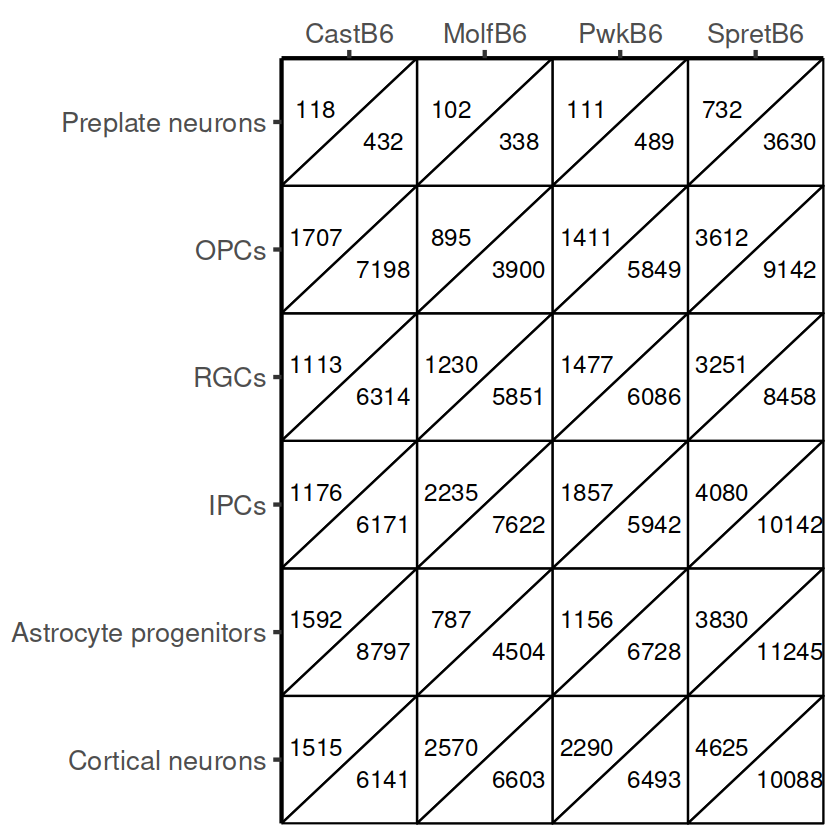

In [22]:
#Make Plot
ggplot(newdata) +
  geom_polygon(aes(x = x, y = y, fill = value, group = interaction(cell_type, strain)), color = "black") +
  scale_fill_gradient(low = "#FFFFFF", high = "#FFFFFF") +
  geom_text(data = newdata_short_sign, aes( x = x, y = y, label = value), size  = 5)+ 
  #ggnewscale::new_scale_fill() +
  geom_polygon(aes(x = xdown, y = ydown, fill = value, group = interaction(cell_type, strain)), color = "black") +
  scale_fill_gradient(low = "#FFFFFF", high =  "#FFFFFF") +
  geom_text(data = newdata_short_tot, aes( x = xdown, y = ydown, label = value), size = 5)+ 
  scale_x_continuous(breaks = seq_along(levels(summary$strain)), 
                     labels = unique(levels(summary$strain)), expand = c(0, 0), position = "top") +
  scale_y_continuous(breaks = seq_along(levels(summary$cell_type)),
                     labels = levels(summary$cell_type),expand = c(0, 0))+
  theme_classic(base_size = 20) + 
  theme( axis.title.x=element_blank(), axis.title.y=element_blank(),
         legend.position = "none")

### Adding log fold change to the definition of allelically imbalanced genes

In [69]:
#summarising data
summary <- all_strains %>%
    group_by(strain, cell_type) %>%
    summarise(tot_genes = n(), signif_genes = length(fdr_shrunk[fdr_shrunk<0.05 &
                                                               abs(log2FC) >= 1]))
head(summary)

strain,cell_type,tot_genes,signif_genes
<chr>,<chr>,<int>,<int>
CastB6,Deep layer neurons,6141,506
CastB6,Gliogenic progenitor cells,8797,776
CastB6,Intermediate neuronal prog,6171,480
CastB6,Neurogenic progenitor cells,6314,436
CastB6,Oligodendrocyte prog,7198,534
CastB6,Preplate neurons,432,42


In [70]:
#converting data into long format
summary <- melt(summary, id.vars = c("strain", "cell_type"))
head(summary)

,strain,cell_type,variable,value
,<chr>,<chr>,<fct>,<int>
1,CastB6,Deep layer neurons,tot_genes,6141
2,CastB6,Gliogenic progenitor cells,tot_genes,8797
3,CastB6,Intermediate neuronal prog,tot_genes,6171
4,CastB6,Neurogenic progenitor cells,tot_genes,6314
5,CastB6,Oligodendrocyte prog,tot_genes,7198
6,CastB6,Preplate neurons,tot_genes,432


In [71]:
summary$cell_type <- recode(summary$cell_type, "Deep layer neurons" = "Cortical neurons", 
                            "Gliogenic progenitor cells" = "Astrocyte progenitors",
                            "Intermediate neuronal prog" = "IPCs",
                            "Neurogenic progenitor cells" = "RGCs",
                            "Oligodendrocyte prog" = "OPCs")
summary$cell_type <- factor(summary$cell_type, levels = c("Cortical neurons", 
                                                          "Astrocyte progenitors",
                                                          "IPCs",
                                                          "RGCs",
                                                          "OPCs",
                                                          "Preplate neurons"))

In [72]:
#reformating dataframe for plotting
newcoord_up <- make_triangles(summary$strain, summary$cell_type)
newcoord_down <- make_triangles(summary$strain, summary$cell_type, point = "down")
newcoord_down <- newcoord_down %>% dplyr::select(xdown = x, ydown = y)
repdata <- map_df(1:nrow(summary), function(i) summary[rep(i, 3), ])
newdata <- bind_cols(repdata, newcoord_up, newcoord_down)

newdata_short = newdata[seq(1, nrow(newdata), 3), ]
newdata_sign =  newdata[newdata$variable == 'signif_genes',]
newdata_tot =  newdata[newdata$variable == 'tot_genes',]
newdata_short_sign = newdata_short[newdata_short$variable == 'signif_genes',]
newdata_short_tot = newdata_short[newdata_short$variable == 'tot_genes',]
newdata_short_sign$x = newdata_short_sign$x + 0.25
newdata_short_sign$y = newdata_short_sign$y + 0.6
newdata_short_tot$xdown = newdata_short_tot$xdown + 0.75
newdata_short_tot$ydown = newdata_short_tot$ydown +0.35


### Plotting the number of allelically imbalanced genes defined using FDR < 0.05 & abs(log2FC) >= 1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


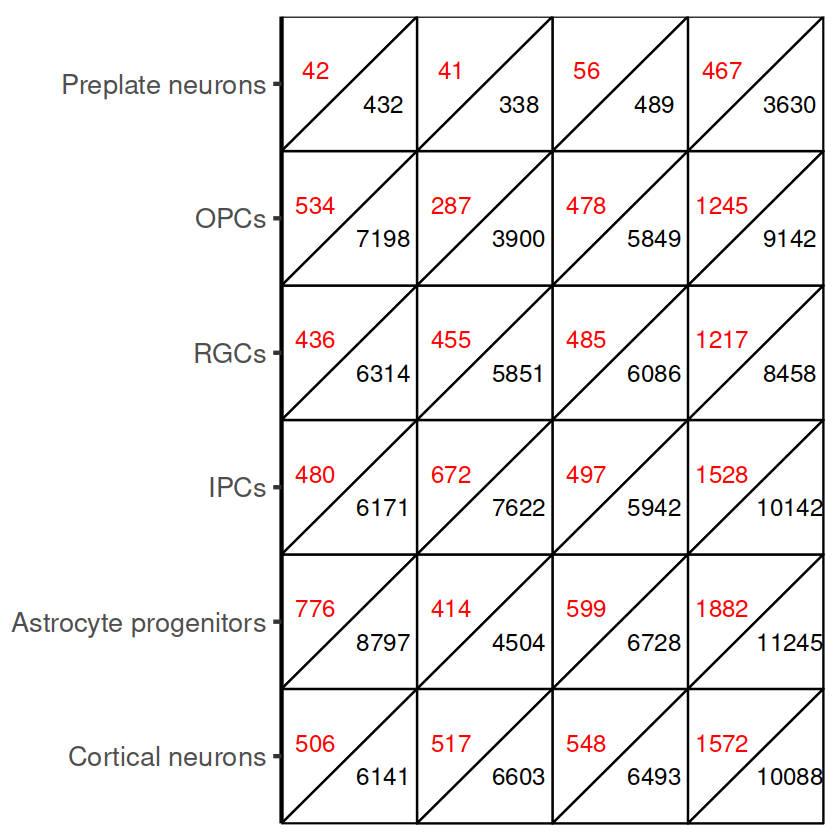

In [74]:
#Make Plot
ggplot(newdata) +
  geom_polygon(aes(x = x, y = y, fill = value, group = interaction(cell_type, strain)), color = "black") +
  scale_fill_gradient(low = "#FFFFFF", high = "#FFFFFF") +
  geom_text(data = newdata_short_sign, aes( x = x, y = y, label = value), size  = 5, color = "red")+ 
  #ggnewscale::new_scale_fill() +
  geom_polygon(aes(x = xdown, y = ydown, fill = value, group = interaction(cell_type, strain)), color = "black") +
  scale_fill_gradient(low = "#FFFFFF", high =  "#FFFFFF") +
  geom_text(data = newdata_short_tot, aes( x = xdown, y = ydown, label = value), size = 5)+ 
  scale_x_continuous(breaks = seq_along(levels(summary$strain)), 
                     labels = unique(levels(summary$strain)), expand = c(0, 0), position = "top") +
  scale_y_continuous(breaks = seq_along(levels(summary$cell_type)),
                     labels = levels(summary$cell_type),expand = c(0, 0))+
  theme_classic(base_size = 20) + 
  theme( axis.title.x=element_blank(), axis.title.y=element_blank(),
         legend.position = "none")